In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, f_oneway, median_test
from collections import defaultdict
from numba import njit


## Implementation of the Shapelet Generation

Here is the original pseudo code from the paper : 

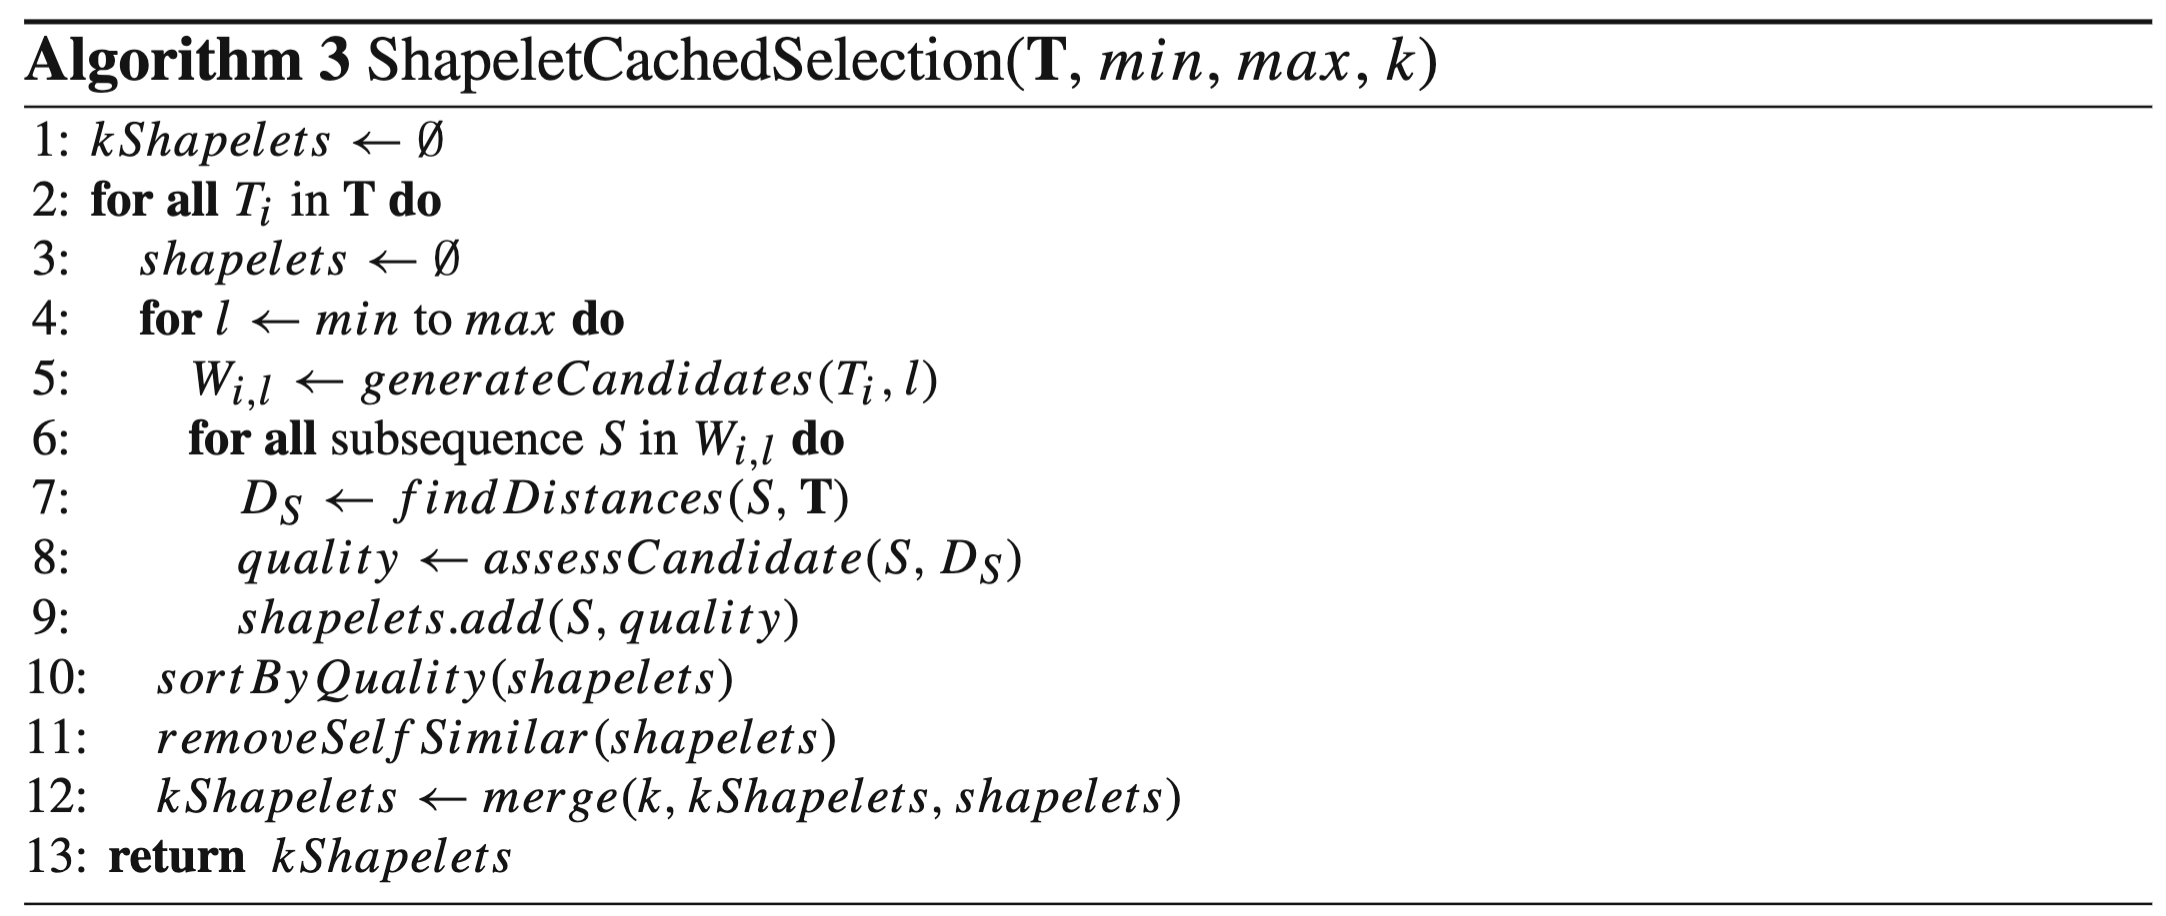

### Utils for handling shapelet data

In [3]:
from dataclasses import dataclass

@dataclass
class Shapelet:
    series_id: int
    start: int
    length: int
    quality: float
    data: any = None  # optionnel


In [25]:
def generateCandidates(t_i,l) :
    """
    Generate m-l+1 shapelet candidates 
    """
    W_i_l = []
    m = t_i.shape[0]
    for j in range(m-l+1) : 
        candidate = t_i[j:j+l]
        W_i_l.append(candidate)
    return W_i_l

In [ ]:
def euclidean_distance(x,y) : 
    return np.sum((x-y)**2)

def z_normalize(x, eps=1e-8):
    mu = np.mean(x)
    sigma = np.std(x)
    if sigma < eps:
        return np.zeros_like(x)
    return (x - mu) / sigma


@njit(fastmath=True)
def findDistances(series_array, shapelet_array):
    """
    Numba optimized version of finding the minimum distance 
    between a shapelet and a dataset of time series.
    series_array: (N, M) array
    shapelet_array: (L,) array
    """
    n_series, series_len = series_array.shape
    shap_len = shapelet_array.shape[0]
    s_mean = np.mean(shapelet_array)
    s_std = np.std(shapelet_array)
    if s_std == 0: s_std = 1.0
    s_norm = (shapelet_array - s_mean) / s_std
    output_distances = np.zeros(n_series)
    
    for i in range(n_series):
        ts = series_array[i]
        best_dist = np.inf
        
        for j in range(series_len - shap_len + 1):
            # --- Inline Z-normalization & Distance ---
            # (Doing this manually in the loop is faster in Numba than calling functions)
            
            # 1. Compute window statistics
            w_sum = 0.0
            w_sq_sum = 0.0
            for k in range(shap_len):
                val = ts[j + k]
                w_sum += val
                w_sq_sum += val * val
            w_mean = w_sum / shap_len
            w_std = np.sqrt((w_sq_sum / shap_len) - (w_mean * w_mean))
            if w_std == 0: w_std = 1.0
            
            # 2. Compute Euclidean distance with Early Abandonment
            current_dist = 0.0
            abandon = False
            for k in range(shap_len):
                val_norm = (ts[j + k] - w_mean) / w_std
                diff = val_norm - s_norm[k]
                current_dist += diff * diff
                # OPTIMIZATION: Early Abandonment
                if current_dist >= best_dist:
                    abandon = True
                    break
            if not abandon:
                best_dist = current_dist                
        output_distances[i] = best_dist
    return output_distances

### Utils for assessing the quality of the shapelets

In [6]:
def split_by_class(D_S, y):
    """
    Return a dict {class: np.array(distances)}
    """
    groups = defaultdict(list)
    for d, label in zip(D_S, y):
        groups[label].append(d)
    return {k: np.array(v) for k, v in groups.items()}

def information_gain(D_S, y):
    """
    Information Gain computation for all different splits
    """
    D_S = np.asarray(D_S)
    y = np.asarray(y)

    order = np.argsort(D_S)
    D_sorted = D_S[order]
    y_sorted = y[order]

    def entropy(labels):
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-12))

    base_entropy = entropy(y_sorted)
    best_ig = 0.0

    for i in range(1, len(D_sorted)):
        left = y_sorted[:i]
        right = y_sorted[i:]
        ig = base_entropy
        ig -= (len(left) / len(y)) * entropy(left)
        ig -= (len(right) / len(y)) * entropy(right)
        best_ig = max(best_ig, ig)

    return best_ig

def f_statistic(D_S, y):
    """
    ANOVA F-statistic 
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    return f_oneway(*groups.values()).statistic

def kruskal_wallis(D_S, y):
    """
    Test of Kruskal-Wallis 
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    return kruskal(*groups.values()).statistic

def moods_median(D_S, y):
    """
    Mood's median test (statistique du test)
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    stat, _, _, _ = median_test(*groups.values())
    return stat

def assessCandidate(D_S, y, method="f_stat"):
    """
    Wrapper function to asses the quality of a shapelet 
    method : {"f_stat", "ig", "kruskal", "median"}
    """
    if method == "f_stat":
        return f_statistic(D_S, y)
    elif method == "ig":
        return information_gain(D_S, y)
    elif method == "kruskal":
        return kruskal_wallis(D_S, y)
    elif method == "median":
        return moods_median(D_S, y)
    else:
        raise ValueError(f"Méthode inconnue : {method}")


In [7]:
def sort_by_quality(shapelets, reverse=True):
    """
    Sort the shapelet by their quality 

    shapelets : liste of tuples (shapelet, quality)
    reverse   : True = best quality in first position
    """
    return sorted(shapelets, key=lambda x: x.quality, reverse=reverse)



In [8]:
def overlaps(s1, s2):
    """
    Check if two shapelets does overlap
    """
    end1 = s1.start + s1.length - 1
    end2 = s2.start + s2.length - 1
    return not (end1 < s2.start or end2 < s1.start)


def remove_self_similar(shapelets):
    """
    - shapelets : list(Shapelet) 
    - shapelets is already ordered by decreasing quality
    """
    filtered = []

    for s in shapelets:
        keep = True
        for kept in filtered:
            if s.series_id == kept.series_id and overlaps(s, kept):
                keep = False
                break
        if keep:
            filtered.append(s)

    return filtered


#### Personal addition

In [40]:
def remove_inter_series_redundancy(shapelets, threshold_ratio=0.2):
    """
    Removes shapelets that are geometrically similar but come from DIFFERENT series.
    threshold_ratio: similarity threshold (e.g., 0.2 means distance must be < 20% of length)
    """
    final_shapelets = []
    
    # assume candidates are already sorted by quality 
    for candidate in shapelets:
        is_redundant = False
        cand_data = z_normalize(candidate.data)
        
        for kept in final_shapelets:
            # We only compare if lengths are similar 
            if len(candidate.data) == len(kept.data):
                kept_data = z_normalize(kept.data)
                
                # Calculate distance between the shapes themselves
                dist = np.linalg.norm(cand_data - kept_data) 
                
                # Heuristic: if distance is small relative to length
                if dist < (threshold_ratio * np.sqrt(len(cand_data))):
                    is_redundant = True
                    break
        
        if not is_redundant:
            final_shapelets.append(candidate)
            
    return final_shapelets

def shapelet_to_shapelet_distance(s1, s2):
    """
    use the finddistance function to find the min distance between two shapelets (using z-norm, sliding)
    """
    return findDistances(np.array([s1.data]), s2.data)[0]

# Second implementation, this time checking also the redudancy 
# between time series of differents sizes 
def greedy_inter_series_filter(shapelets, K, tau):
    """
    shapelets : list[Shapelet] (déjà triées par qualité décroissante)
    """
    selected = []

    for s in shapelets:
        keep = True
        for s_sel in selected:
            if shapelet_to_shapelet_distance(s, s_sel) < tau:
                keep = False
                break

        if keep:
            selected.append(s)

        if len(selected) == K:
            break

    return selected

#### Back to paper

In [29]:
def merge(k, k_shapelets, new_shapelets):
    """
    Merge the new shapelets with the old ones and keep the k best 

    Parameters
    ----------
    k : int
        max number of shapelets to keep
    k_shapelets : list[Shapelet]
        old shapelets 
    new_shapelets : list[Shapelet]
        New shapelets 

    Returns 
    ------
    list[Shapelet]
        top-k shapelets sorted by decreasing quality
    """
    merged = k_shapelets + new_shapelets
    merged.sort(key=lambda s: s.quality, reverse=True)
    return merged[:k]

In [30]:
def ShapeletCachedSelection(
    T,
    y,
    min_len,
    max_len,
    k,
    quality_method="f_stat"
):
    """
    Implementation of the algorithm 3 

    Parameters : 
    ----------
    T : np.ndarray (n_series, series_length)
        Dataset of time series
    y : np.ndarray (n_series,)
        Labels 
    min_len : int
        minimum lenght of the shapelets 
    max_len : int
        maximum lenght of the shapelets
    k : int
        Number of Shapelets kept 
    quality_method : str
        {"f_stat", "ig", "kruskal", "median"}

    Returns : 
    ------
    list[Shapelet]
        containing the k best Shapelets 
    """
    n_series, series_length = T.shape
    kShapelets = []  
    for series_id in range(n_series):
        t = T[series_id]
        shapelets = []  
        for l in range(min_len, max_len + 1):
            if l > series_length:
                continue
            for start in range(series_length - l + 1):
                S = t[start:start + l]
                D_S = findDistances(T, S)
                quality = assessCandidate(D_S, y, method=quality_method)
                shapelets.append(
                    Shapelet(
                        series_id=series_id,
                        start=start,
                        length=l,
                        quality=quality,
                        data=S
                    )
                )
        shapelets = sort_by_quality(shapelets)
        shapelets = remove_self_similar(shapelets)
        kShapelets = merge(k, kShapelets, shapelets)

    return kShapelets


In [31]:
def EstimateMinAndMax(T, y):
    """
    Heuristic to find min_len and max_len (Algorithm 4 in the paper)
    """
    n_samples = min(10, len(T))
    indices = np.random.choice(len(T), n_samples, replace=False)
    sub_T = T[indices]
    sub_y = y[indices]
    
    # Run a quick search with broad limits
    # (e.g., from 3 to length/2)
    quick_shapelets = ShapeletCachedSelection(
        sub_T, sub_y, 
        min_len=3, max_len=T.shape[1]//2, 
        k=10, quality_method="f_stat"
    )
    
    lengths = sorted([s.length for s in quick_shapelets])
    if not lengths:
        return 3, T.shape[1]//2
        
    min_l = lengths[len(lengths)//4] # 25th percentile
    max_l = lengths[3*len(lengths)//4] # 75th percentile
    
    return min_l, max_l

## Sanity Check with toy dataset

In [13]:
np.random.seed(0)

def generate_synthetic_dataset(
    n_series=20,
    series_length=100,
    shapelet_length=15
):
    X = np.random.normal(0, 1, (n_series, series_length))
    y = np.zeros(n_series, dtype=int)

    # shapelets for each class
    shapelet_A = np.sin(np.linspace(0, np.pi, shapelet_length))
    shapelet_B = -shapelet_A

    for i in range(n_series):
        pos = np.random.randint(0, series_length - shapelet_length)
        if i < n_series // 2:
            X[i, pos:pos+shapelet_length] += shapelet_A
            y[i] = 0
        else:
            X[i, pos:pos+shapelet_length] += shapelet_B
            y[i] = 1

    return X, y, shapelet_A, shapelet_B


X, y, true_A, true_B = generate_synthetic_dataset()


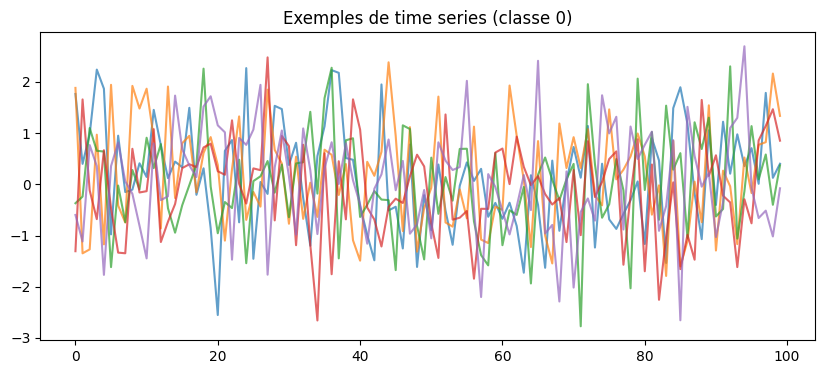

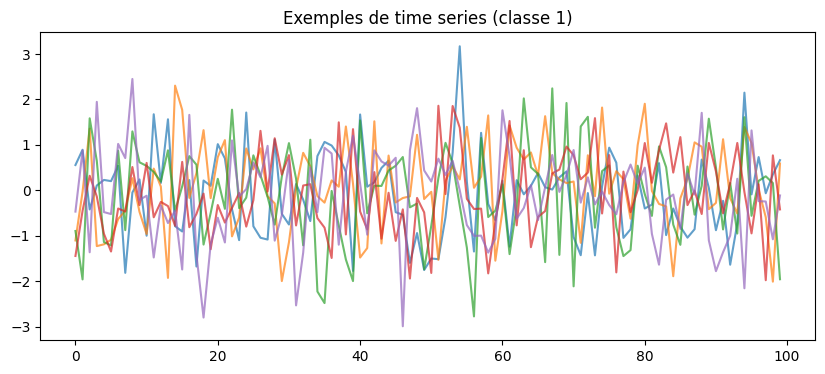

In [14]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(X[i], alpha=0.7)
plt.title("Exemples de time series (classe 0)")
plt.show()

plt.figure(figsize=(10, 4))
for i in range(10, 15):
    plt.plot(X[i], alpha=0.7)
plt.title("Exemples de time series (classe 1)")
plt.show()


In [ ]:
k_shapelets = ShapeletCachedSelection(
    T=X,
    y=y,
    min_len=10,
    max_len=20,
    k=5,
    quality_method="f_stat"
)

print("Shapelets sélectionnés :")
for s in k_shapelets:
    print(
        f"series={s.series_id}, start={s.start}, "
        f"len={s.length}, quality={s.quality:.3f}"
    )

    
plt.figure(figsize=(8, 4))
for i, s in enumerate(k_shapelets):
    plt.plot(z_normalize(s.data), label=f"S{i}")
plt.title("Shapelets extraits (normalisés)")
plt.legend()
plt.show()


In [ ]:
best_shapelet = k_shapelets[0]
D = findDistances(X, best_shapelet.data)
plt.figure(figsize=(6, 4))
plt.hist(D[y == 0], bins=10, alpha=0.7, label="Classe 0")
plt.hist(D[y == 1], bins=10, alpha=0.7, label="Classe 1")
plt.xlabel("Distance au shapelet")
plt.ylabel("Fréquence")
plt.title("Séparation induite par le shapelet")
plt.legend()
plt.show()


In [ ]:
s = best_shapelet
t = X[s.series_id]

plt.figure(figsize=(10, 4))
plt.plot(t, label="Time series")
plt.axvspan(
    s.start,
    s.start + s.length,
    color="red",
    alpha=0.3,
    label="Shapelet"
)
plt.legend()
plt.title("Localisation du shapelet dans sa série d'origine")
plt.show()


## Experiment on Gunpoint

In [21]:
import requests
import zipfile
import io
import numpy as np

def load_gunpoint():
    url = "https://www.timeseriesclassification.com/aeon-toolkit/GunPoint.zip"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
    }
    print(f"Downloading GunPoint from {url}...")
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        raise Exception(f"Failed to download. Status: {r.status_code}\nResponse: {r.text[:200]}")   
    if r.content[:2] != b'PK': # Check if it looks like a zip (starts with PK)
        raise Exception("The downloaded file is not a zip archive. It might be an HTML page.")
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except zipfile.BadZipFile:
        with open("debug_download.html", "wb") as f:
            f.write(r.content)
        raise Exception("BadZipFile error. Saved 'debug_download.html' for inspection.")
    print("Files in archive:", z.namelist())
    
    # Note: The file names inside the zip might be 'GunPoint_TRAIN.txt' or 'GunPoint_TRAIN.ts'
    # We try .txt first (standard legacy format), then .ts
    try:
        train_file = z.open('GunPoint_TRAIN.txt')
        test_file  = z.open('GunPoint_TEST.txt')
    except KeyError:
        # Fallback for newer archives which use .ts
        print("Text files not found, looking for .ts files...")
        # Note: .ts files require a specific parser, standard np.loadtxt won't work directly 
        # unless it's the simpler CSV-like version. 
        # If you hit this, you might need to use 'aeon' or 'scipy.io.arff'
        raise Exception("Could not find GunPoint_TRAIN.txt. The archive format might have changed to .ts")

    train = np.loadtxt(train_file)
    test  = np.loadtxt(test_file)
    
    X_train = train[:, 1:]
    y_train = train[:, 0].astype(int)
    
    X_test = test[:, 1:]
    y_test = test[:, 0].astype(int)
    
    print(f"Loaded GunPoint: Train {X_train.shape}, Test {X_test.shape}")
    return X_train, y_train, X_test, y_test

# Run the function
X_train, y_train, X_test, y_test = load_gunpoint()

Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)


Estimated parameters: min_len=28, max_len=42

--- 1. Baseline: Standard Shapelet Transform ---
Extracting top 50 shapelets (Standard)...

--- 2. Our Method: Inter-Series Redundancy Filter ---
Reduced feature space from 50 -> 34 features.

--- 3. Training Classifiers ---
Transforming dataset shape (50, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (50, 150) with 34 shapelets...
Transforming dataset shape (150, 150) with 34 shapelets...

FINAL RESULTS TABLE
                Method  Num Features Accuracy Reduction
0  Standard (Baseline)            50   0.9667         -
1     Clustered (Ours)            34   0.9600     32.0%


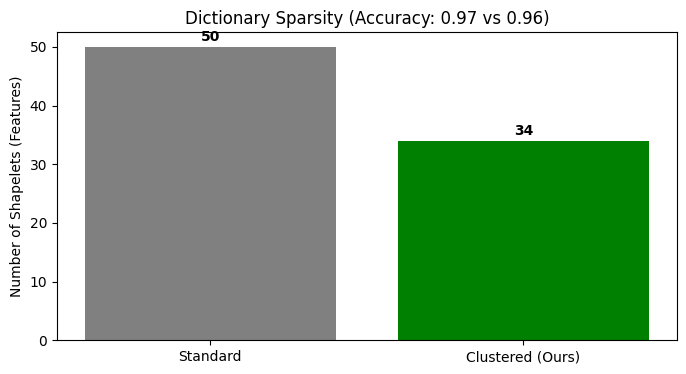

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Helper: Transform Time Series to Distance Matrix ---
def transform_dataset(X, shapelets):
    n_samples = len(X)
    n_features = len(shapelets)
    X_new = np.zeros((n_samples, n_features))
    
    print(f"Transforming dataset shape {X.shape} with {n_features} shapelets...")
    for i, s in enumerate(shapelets):
        X_new[:, i] = findDistances(X, s.data)
        
    return X_new

# --- 1. SETUP EXPERIMENT ---
if 'X_train' not in locals():
    X_train, y_train, X_test, y_test = load_gunpoint()

# Estimate parameters
min_l, max_l = EstimateMinAndMax(X_train, y_train)
print(f"Estimated parameters: min_len={min_l}, max_len={max_l}")

# --- 2. EXTRACT BASELINE (STANDARD METHOD) ---
print("\n--- 1. Baseline: Standard Shapelet Transform ---")
k_baseline = 50
print(f"Extracting top {k_baseline} shapelets (Standard)...")

baseline_shapelets = ShapeletCachedSelection(
    X_train, y_train, 
    min_len=min_l, 
    max_len=max_l, 
    k=k_baseline, 
    quality_method="f_stat"
)

# --- 3. APPLY YOUR CONTRIBUTION (CLUSTERED METHOD) ---
print("\n--- 2. Our Method: Inter-Series Redundancy Filter ---")
# CORRECTED LINE:
clustered_shapelets = remove_inter_series_redundancy(baseline_shapelets, threshold_ratio=0.25)
k_ours = len(clustered_shapelets)
print(f"Reduced feature space from {k_baseline} -> {k_ours} features.")

# --- 4. EVALUATION (CLASSIFICATION ACCURACY) ---
print("\n--- 3. Training Classifiers ---")

# A. Transform Data for Baseline
X_train_base = transform_dataset(X_train, baseline_shapelets)
X_test_base  = transform_dataset(X_test, baseline_shapelets)

# B. Transform Data for Ours
X_train_ours = transform_dataset(X_train, clustered_shapelets)
X_test_ours  = transform_dataset(X_test, clustered_shapelets)

# C. Train & Test (using Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Baseline Results
clf.fit(X_train_base, y_train)
acc_base = accuracy_score(y_test, clf.predict(X_test_base))

# Our Results
clf.fit(X_train_ours, y_train)
acc_ours = accuracy_score(y_test, clf.predict(X_test_ours))

# --- 5. REPORT RESULTS ---
results = pd.DataFrame({
    'Method': ['Standard (Baseline)', 'Clustered (Ours)'],
    'Num Features': [k_baseline, k_ours],
    'Accuracy': [f"{acc_base:.4f}", f"{acc_ours:.4f}"],
    'Reduction': ['-', f"{(1 - k_ours/k_baseline)*100:.1f}%"]
})

print("\n" + "="*40)
print("FINAL RESULTS TABLE")
print("="*40)
print(results)
print("="*40)

# Quick Plot
plt.figure(figsize=(8, 4))
plt.bar(['Standard', 'Clustered (Ours)'], [k_baseline, k_ours], color=['gray', 'green'])
plt.title(f"Dictionary Sparsity (Accuracy: {acc_base:.2f} vs {acc_ours:.2f})")
plt.ylabel("Number of Shapelets (Features)")
for i, v in enumerate([k_baseline, k_ours]):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.show()

### Accuracy vs. k

Running Sensitivity Analysis (k vs Accuracy)...
Transforming dataset shape (50, 150) with 1 shapelets...
Transforming dataset shape (150, 150) with 1 shapelets...
k=1: Accuracy=0.9000
Transforming dataset shape (50, 150) with 5 shapelets...
Transforming dataset shape (150, 150) with 5 shapelets...
k=5: Accuracy=0.9467
Transforming dataset shape (50, 150) with 10 shapelets...
Transforming dataset shape (150, 150) with 10 shapelets...
k=10: Accuracy=0.9467
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
k=20: Accuracy=0.9467
Transforming dataset shape (50, 150) with 30 shapelets...
Transforming dataset shape (150, 150) with 30 shapelets...
k=30: Accuracy=0.9533
Transforming dataset shape (50, 150) with 40 shapelets...
Transforming dataset shape (150, 150) with 40 shapelets...
k=40: Accuracy=0.9733
Transforming dataset shape (50, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
k=50: A

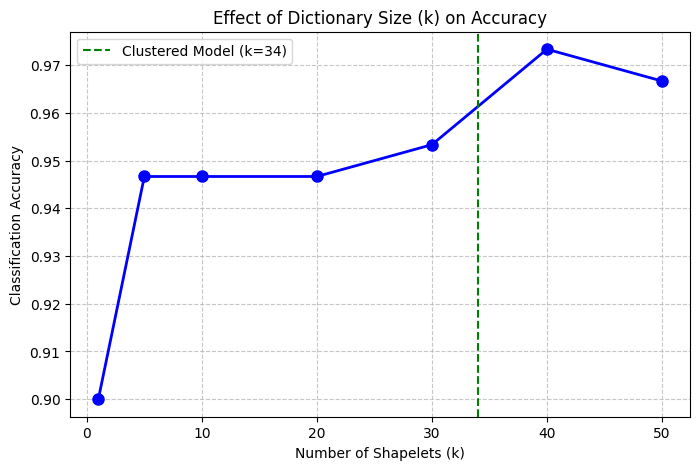

In [32]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- EXPERIMENT: SENSITIVITY TO K (NUMBER OF SHAPELETS) ---
# We use 'baseline_shapelets' from the previous step
# (Make sure you ran the previous cell!)

k_values = [1, 5, 10, 20, 30, 40, 50]
accuracies = []

print("Running Sensitivity Analysis (k vs Accuracy)...")

for k in k_values:
    # 1. Select top k from your existing baseline set
    current_shapelets = baseline_shapelets[:k]
    
    # 2. Transform the data
    X_train_k = transform_dataset(X_train, current_shapelets)
    X_test_k  = transform_dataset(X_test, current_shapelets)
    
    # 3. Train Classifier
    clf_k = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_k.fit(X_train_k, y_train)
    
    # 4. Score
    acc = accuracy_score(y_test, clf_k.predict(X_test_k))
    accuracies.append(acc)
    print(f"k={k}: Accuracy={acc:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
plt.title("Effect of Dictionary Size (k) on Accuracy")
plt.xlabel("Number of Shapelets (k)")
plt.ylabel("Classification Accuracy")
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Add a vertical line for your Clustered model size
# (Update 'k_ours' with the number you got, e.g., 35)
if 'k_ours' in locals():
    plt.axvline(x=k_ours, color='green', linestyle='--', label=f"Clustered Model (k={k_ours})")
    plt.legend()

plt.show()

### Robustness to Noise

Training models on clean data...
Transforming dataset shape (50, 150) with 34 shapelets...

Running Noise Robustness Test (this may take a moment)...
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.0: Shapelet Acc=0.960 | Baseline Acc=0.913
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.5: Shapelet Acc=0.493 | Baseline Acc=0.887
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.0: Shapelet Acc=0.493 | Baseline Acc=0.807
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.5: Shapelet Acc=0.493 | Baseline Acc=0.767
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=2.0: Shapelet Acc=0.493 | Baseline Acc=0.653
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=2.5: Shapelet Acc=0.493 | Baseline Acc=0.707


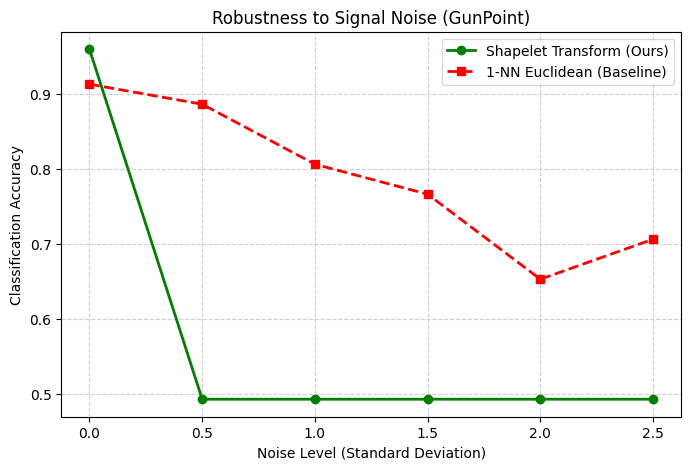

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- EXPERIMENT: ROBUSTNESS TO NOISE ---

# 1. SETUP MODELS
# We use the best model you found: 'clustered_shapelets'
# (Make sure you ran the 'Standard vs Clustered' cell first!)
print("Training models on clean data...")

# A. Shapelet Model (Ours)
# Transform training data once
X_train_shap = transform_dataset(X_train, clustered_shapelets)
clf_shap = RandomForestClassifier(n_estimators=100, random_state=42)
clf_shap.fit(X_train_shap, y_train)

# B. Baseline Model (1-NN Euclidean)
# Trains directly on raw time series
clf_base = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf_base.fit(X_train, y_train)

# 2. RUN NOISE TEST
noise_levels = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5] # Increasing noise std dev
acc_shapelet = []
acc_baseline = []

print("\nRunning Noise Robustness Test (this may take a moment)...")

for sigma in noise_levels:
    # Add noise to TEST data only (simulate noisy environment)
    noise = np.random.normal(0, sigma, X_test.shape)
    X_test_noisy = X_test + noise
    
    # -- Test Shapelet Model --
    # Crucial: We must re-transform the noisy data to distance space
    X_test_shap_noisy = transform_dataset(X_test_noisy, clustered_shapelets)
    acc_s = accuracy_score(y_test, clf_shap.predict(X_test_shap_noisy))
    acc_shapelet.append(acc_s)
    
    # -- Test Baseline (1-NN) --
    acc_b = accuracy_score(y_test, clf_base.predict(X_test_noisy))
    acc_baseline.append(acc_b)
    
    print(f"Noise={sigma}: Shapelet Acc={acc_s:.3f} | Baseline Acc={acc_b:.3f}")

# 3. PLOT RESULTS
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, acc_shapelet, 'g-o', linewidth=2, label="Shapelet Transform (Ours)")
plt.plot(noise_levels, acc_baseline, 'r--s', linewidth=2, label="1-NN Euclidean (Baseline)")

plt.title("Robustness to Signal Noise (GunPoint)")
plt.xlabel("Noise Level (Standard Deviation)")
plt.ylabel("Classification Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### SVM vs RandomForest

Training classifiers on clean data...
Transforming dataset shape (50, 150) with 34 shapelets...

Running Noise Comparison (RF vs SVM)...
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.0: RF=0.960 | SVM=0.973
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.5: RF=0.493 | SVM=0.493
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.0: RF=0.493 | SVM=0.493
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.5: RF=0.493 | SVM=0.493
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=2.0: RF=0.493 | SVM=0.493


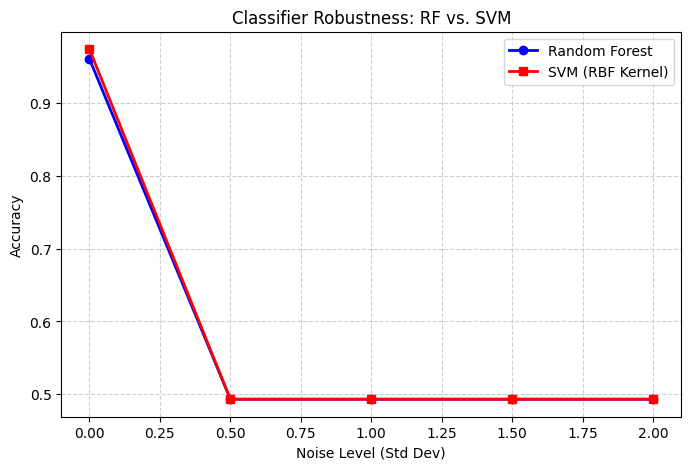

In [34]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# --- EXPERIMENT: RF vs. SVM on Noisy Data ---

# 1. SETUP CLASSIFIERS
# RF: Standard (what you used before)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# SVM: Requires Scaling! We use a Pipeline (Scaler -> SVM)
# 'C' controls regularization (Lower C = wider margin, better for noise)
svm_clf = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', C=1.0, probability=True) 
)

# Train both on CLEAN data first
# We use 'clustered_shapelets' (your best set)
print("Training classifiers on clean data...")
X_train_trans = transform_dataset(X_train, clustered_shapelets)

rf_clf.fit(X_train_trans, y_train)
svm_clf.fit(X_train_trans, y_train)

# 2. RUN NOISE LOOP
noise_levels = [0.0, 0.5, 1.0, 1.5, 2.0]
rf_scores = []
svm_scores = []

print("\nRunning Noise Comparison (RF vs SVM)...")

for sigma in noise_levels:
    # Create Noisy Test Set
    noise = np.random.normal(0, sigma, X_test.shape)
    X_test_noisy = X_test + noise
    
    # Transform (Distances to shapelets)
    # Note: The distances themselves will be larger due to noise
    X_test_trans = transform_dataset(X_test_noisy, clustered_shapelets)
    
    # Evaluate RF
    acc_rf = accuracy_score(y_test, rf_clf.predict(X_test_trans))
    rf_scores.append(acc_rf)
    
    # Evaluate SVM
    acc_svm = accuracy_score(y_test, svm_clf.predict(X_test_trans))
    svm_scores.append(acc_svm)
    
    print(f"Noise={sigma}: RF={acc_rf:.3f} | SVM={acc_svm:.3f}")

# 3. PLOT
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, rf_scores, 'b-o', linewidth=2, label="Random Forest")
plt.plot(noise_levels, svm_scores, 'r-s', linewidth=2, label="SVM (RBF Kernel)")

plt.title("Classifier Robustness: RF vs. SVM")
plt.xlabel("Noise Level (Std Dev)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Sensitivity to Speed Changes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- SETUP ---
# 1. Train "Article" Model (Standard)
if 'baseline_shapelets' in locals():
    print("Training Article Model (Standard)...")
    X_train_base = transform_dataset(X_train, baseline_shapelets)
    clf_article = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_article.fit(X_train_base, y_train)
else:
    print("Error: 'baseline_shapelets' not found. Run the comparison block first!")

# 2. Train "Our" Model (Clustered)
print("Training Our Model (Clustered)...")
X_train_ours = transform_dataset(X_train, clustered_shapelets)
clf_ours = RandomForestClassifier(n_estimators=100, random_state=42)
clf_ours.fit(X_train_ours, y_train)

# 3. Train Baseline (1-NN)
clf_1nn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf_1nn.fit(X_train, y_train)

# --- RUN EXPERIMENT ---
warp_ratios = [0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2]
acc_article = []
acc_ours = []
acc_1nn = []

print("\nRunning Warping Comparison...")

for r in warp_ratios:
    # Warp test set
    X_test_warped = warp_dataset(X_test, ratio=r)
    
    # 1. Test Article (Standard)
    X_test_base_warped = transform_dataset(X_test_warped, baseline_shapelets)
    acc_article.append(accuracy_score(y_test, clf_article.predict(X_test_base_warped)))
    
    # 2. Test Ours (Clustered)
    X_test_ours_warped = transform_dataset(X_test_warped, clustered_shapelets)
    acc_ours.append(accuracy_score(y_test, clf_ours.predict(X_test_ours_warped)))
    
    # 3. Test 1-NN (Fixed Length)
    X_test_fixed = resize_dataset(X_test_warped, target_length=X_train.shape[1])
    acc_1nn.append(accuracy_score(y_test, clf_1nn.predict(X_test_fixed)))
    
    print(f"Ratio {r}: Art={acc_article[-1]:.3f} | Ours={acc_ours[-1]:.3f}")

# --- PLOT ---
plt.figure(figsize=(8, 5))
plt.plot(warp_ratios, acc_article, 'b-o', linewidth=2, label="Article (Standard)")
plt.plot(warp_ratios, acc_ours, 'g-^', linewidth=2, label="Ours (Clustered)")
plt.plot(warp_ratios, acc_1nn, 'r--s', linewidth=2, label="1-NN Euclidean")

plt.title("Robustness to Time Warping: Standard vs. Ours")
plt.xlabel("Speed Ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Blackout (Occlusion) Test

In [ ]:
# --- EXPERIMENT 2: OCCLUSION COMPARISON ---
window_size = 20
step_size = 5
series_len = X_test.shape[1]

positions = []
acc_occ_article = []
acc_occ_ours = []
acc_occ_1nn = []

print(f"\nRunning Occlusion Comparison...")

for start in range(0, series_len - window_size, step_size):
    end = start + window_size
    mid = start + window_size // 2
    positions.append(mid)
    
    # Create occluded copy
    X_test_occ = X_test.copy()
    X_test_occ[:, start:end] = 0.0
    
    # 1. Test Article
    X_test_base_occ = transform_dataset(X_test_occ, baseline_shapelets)
    acc_occ_article.append(accuracy_score(y_test, clf_article.predict(X_test_base_occ)))
    
    # 2. Test Ours
    X_test_ours_occ = transform_dataset(X_test_occ, clustered_shapelets)
    acc_occ_ours.append(accuracy_score(y_test, clf_ours.predict(X_test_ours_occ)))
    
    # 3. Test 1-NN
    acc_occ_1nn.append(accuracy_score(y_test, clf_1nn.predict(X_test_occ)))

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(positions, acc_occ_article, 'b-', linewidth=2, label="Article (Standard)")
plt.plot(positions, acc_occ_ours, 'g--', linewidth=2, label="Ours (Clustered)")
plt.plot(positions, acc_occ_1nn, 'r:', linewidth=1, alpha=0.7, label="1-NN")

plt.title(f"Occlusion Sensitivity (Window={window_size})")
plt.xlabel("Occlusion Position")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Data Starvation Test (Sample Efficiency)

In [ ]:
# --- EXPERIMENT 3: DATA STARVATION COMPARISON ---
from sklearn.model_selection import StratifiedShuffleSplit

subset_sizes = [4, 8, 12, 16, 20, 30, 40]
n_repeats = 10

acc_starve_article = []
acc_starve_ours = []
acc_starve_1nn = []

print("\nRunning Data Starvation Comparison...")

for n in subset_sizes:
    s_art, s_ours, s_1nn = [], [], []
    
    for i in range(n_repeats):
        # Subsample Train
        sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=i*n)
        for train_idx, _ in sss.split(X_train, y_train):
            X_sub = X_train[train_idx]
            y_sub = y_train[train_idx]
            
        # 1. Article (Standard)
        X_sub_base = transform_dataset(X_sub, baseline_shapelets)
        clf_a = RandomForestClassifier(n_estimators=50, random_state=42)
        clf_a.fit(X_sub_base, y_sub)
        # Eval
        X_test_base = transform_dataset(X_test, baseline_shapelets)
        s_art.append(accuracy_score(y_test, clf_a.predict(X_test_base)))
        
        # 2. Ours (Clustered)
        X_sub_ours = transform_dataset(X_sub, clustered_shapelets)
        clf_o = RandomForestClassifier(n_estimators=50, random_state=42)
        clf_o.fit(X_sub_ours, y_sub)
        # Eval
        X_test_ours = transform_dataset(X_test, clustered_shapelets)
        s_ours.append(accuracy_score(y_test, clf_o.predict(X_test_ours)))
        
        # 3. 1-NN
        clf_b = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
        clf_b.fit(X_sub, y_sub)
        s_1nn.append(accuracy_score(y_test, clf_b.predict(X_test)))
        
    acc_starve_article.append(np.mean(s_art))
    acc_starve_ours.append(np.mean(s_ours))
    acc_starve_1nn.append(np.mean(s_1nn))
    
    print(f"N={n}: Art={acc_starve_article[-1]:.2f} | Ours={acc_starve_ours[-1]:.2f}")

# --- PLOT ---
plt.figure(figsize=(8, 5))
plt.plot(subset_sizes, acc_starve_article, 'b-o', label="Article (Standard)")
plt.plot(subset_sizes, acc_starve_ours, 'g-^', label="Ours (Clustered)")
plt.plot(subset_sizes, acc_starve_1nn, 'r--s', label="1-NN Euclidean")

plt.title("Sample Efficiency: Standard vs. Ours")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Comparison between Top-M + clustering post-hoc (Hills et al.) (PIPELINE P1) and Greedy clustering (PIPELINE P2) 

In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def cluster_shapelets_posthoc(shapelets, K):
    n = len(shapelets)
    D = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            d = shapelet_to_shapelet_distance(shapelets[i], shapelets[j])
            if not np.isfinite(d):
                d = np.inf
            D[i, j] = D[j, i] = d

    # Replace inf with a large finite value before clustering
    max_finite = np.max(D[np.isfinite(D)]) if np.any(np.isfinite(D)) else 1.0
    D[~np.isfinite(D)] = max_finite * 10.0

    Z = linkage(squareform(D), method="average")
    labels = fcluster(Z, t=K, criterion="maxclust")

    selected = []
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        best = idx[np.argmax([shapelets[i].quality for i in idx])]
        selected.append(shapelets[best])

    return selected


def run_pipeline_P1(Xtr, ytr, Xte, yte, min_len, max_len, M, K):
    # Discovery
    shapelets = ShapeletCachedSelection(
        Xtr, ytr, min_len, max_len, k=M, quality_method="f_stat"
    )
    shapelets = sort_by_quality(shapelets)
    shapelets = remove_self_similar(shapelets)

    # Post-hoc clustering
    shapelets_K = cluster_shapelets_posthoc(shapelets, K)


    Xtr_t = transform_dataset(Xtr, shapelets_K)
    Xte_t = transform_dataset(Xte, shapelets_K)

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(Xtr_t, ytr)
    acc = accuracy_score(yte, clf.predict(Xte_t))

    return acc, shapelets_K


def run_pipeline_P2(Xtr, ytr, Xte, yte, min_len, max_len, M, K, tau):
    shapelets = ShapeletCachedSelection(
        Xtr, ytr, min_len, max_len, k=M, quality_method="f_stat"
    )
    shapelets = sort_by_quality(shapelets)
    shapelets_K = remove_inter_series_redundancy(shapelets, threshold_ratio=0.25)
    Xtr_t = transform_dataset(Xtr, shapelets_K)
    Xte_t = transform_dataset(Xte, shapelets_K)

    
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(Xtr_t, ytr)
    acc = accuracy_score(yte, clf.predict(Xte_t))

    return acc, shapelets_K




In [46]:
Ks = [10, 20, 35]
tau = 0.25     # tu peux l’ajuster UNE FOIS si besoin
M = 50         # budget initial identique
X_train, y_train, X_test, y_test = load_gunpoint()
min_l, max_l = EstimateMinAndMax(X_train, y_train)

for K in Ks:
    acc_p1, shp_p1 = run_pipeline_P1(
        X_train, y_train, X_test, y_test,
        min_l, max_l,
        M, K
    )

    acc_p2, shp_p2 = run_pipeline_P2(
        X_train, y_train, X_test, y_test,
        min_l, max_l,
        M, K,
        tau
    )

    print(f"K={K:2d} | P1 acc={acc_p1:.4f} | P2 acc={acc_p2:.4f}")


Transforming dataset shape (50, 150) with 10 shapelets...
Transforming dataset shape (150, 150) with 10 shapelets...
Transforming dataset shape (50, 150) with 37 shapelets...
Transforming dataset shape (150, 150) with 37 shapelets...
K=10 | P1 acc=0.9600 | P2 acc=0.9733
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 37 shapelets...
Transforming dataset shape (150, 150) with 37 shapelets...
K=20 | P1 acc=0.9867 | P2 acc=0.9733
Transforming dataset shape (50, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (50, 150) with 37 shapelets...
Transforming dataset shape (150, 150) with 37 shapelets...
K=35 | P1 acc=0.9533 | P2 acc=0.9733


In [47]:
length_ranges = [
    (16, 24),   # shapelets courts
    (24, 32),
    (32, 47),   # plage "papier"
    (47, 64),   # shapelets plus longs
]

K = 20
M = 50
tau = 0.25

X_train, y_train, X_test, y_test = load_gunpoint()

def dictionary_diversity(shapelets):
    dists = []
    for i in range(len(shapelets)):
        for j in range(i+1, len(shapelets)):
            dists.append(
                shapelet_to_shapelet_distance(shapelets[i], shapelets[j])
            )
    return np.mean(dists)


results = []

for (min_len, max_len) in length_ranges:
    acc_p1, shp_p1 = run_pipeline_P1(
        X_train, y_train, X_test, y_test,
        min_len, max_len,
        M, K
    )

    acc_p2, shp_p2 = run_pipeline_P2(
        X_train, y_train, X_test, y_test,
        min_len, max_len,
        M, K,
        tau
    )

    div_p1 = dictionary_diversity(shp_p1)
    div_p2 = dictionary_diversity(shp_p2)

    results.append({
        "min_len": min_len,
        "max_len": max_len,
        "P1_acc": acc_p1,
        "P2_acc": acc_p2,
        "div_p1": div_p1,
        "div_p2": div_p2
    })

    print(
        f"[{min_len:2d}, {max_len:2d}] | "
        f"P1={acc_p1:.4f} | P2={acc_p2:.4f}"
    )




Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 27 shapelets...
Transforming dataset shape (150, 150) with 27 shapelets...
[16, 24] | P1=0.9933 | P2=0.9867
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 30 shapelets...
Transforming dataset shape (150, 150) with 30 shapelets...
[24, 32] | P1=0.9733 | P2=0.9867
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
[32, 47] | P1=0.97

KeyboardInterrupt: 

### Heatmaps for different lenghts 

In [48]:
min_lens = [12, 16, 20, 24, 28]
max_lens = [24, 32, 40, 48, 56]

records = []

for min_len in min_lens:
    for max_len in max_lens:
        if min_len >= max_len:
            continue

        acc_p1, shp_p1 = run_pipeline_P1(
            X_train, y_train, X_test, y_test,
            min_len, max_len,
            M, K
        )

        acc_p2, shp_p2 = run_pipeline_P2(
            X_train, y_train, X_test, y_test,
            min_len, max_len,
            M, K,
            tau
        )

        records.append({
            "min_len": min_len,
            "max_len": max_len,
            "P1_acc": acc_p1,
            "P2_acc": acc_p2,
            "P1_div": dictionary_diversity(shp_p1),
            "P2_div": dictionary_diversity(shp_p2),
        })

df_l_variation = pd.DataFrame(records)

Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 29 shapelets...
Transforming dataset shape (150, 150) with 29 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 38 shapelets...
Transforming dataset shape (150, 150) with 38 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 39 shapelets...
Transforming dataset shape (150, 150) with 39 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transf

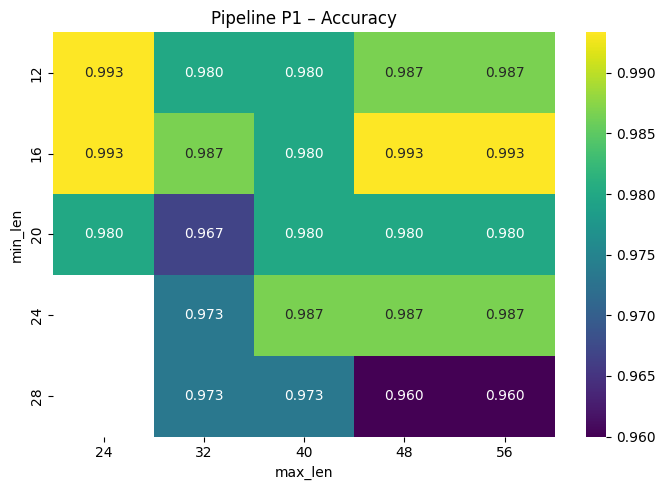

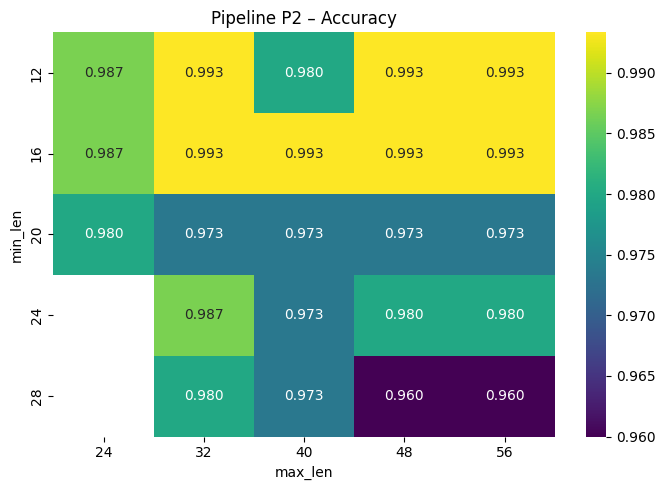

In [49]:
import seaborn as sns


def plot_heatmap(df, value, title):
    pivot = df.pivot(
        index="min_len",
        columns="max_len",
        values=value
    )

    plt.figure(figsize=(7, 5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".3f",
        cmap="viridis"
    )
    plt.title(title)
    plt.xlabel("max_len")
    plt.ylabel("min_len")
    plt.tight_layout()
    plt.show()

plot_heatmap(df_l_variation, "P1_acc", "Pipeline P1 – Accuracy")
plot_heatmap(df_l_variation, "P2_acc", "Pipeline P2 – Accuracy")


# Other datasets 

In [50]:
def run_shapelet_report(
    dataset_name,
    load_fn,
    k_baseline=50,
    tau=0.25,
    clf=None,
):
    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*60}")

    X_train, y_train, X_test, y_test = load_fn()

    min_l, max_l = EstimateMinAndMax(X_train, y_train)
    print(f"Estimated lengths: [{min_l}, {max_l}]")

    baseline_shapelets = ShapeletCachedSelection(
        X_train, y_train,
        min_len=min_l,
        max_len=max_l,
        k=k_baseline,
        quality_method="f_stat"
    )

    clustered_shapelets = remove_inter_series_redundancy(
        baseline_shapelets,
        threshold_ratio=tau
    )


    Xtr_base = transform_dataset(X_train, baseline_shapelets)
    Xte_base = transform_dataset(X_test, baseline_shapelets)
    Xtr_ours = transform_dataset(X_train, clustered_shapelets)
    Xte_ours = transform_dataset(X_test, clustered_shapelets)

    if clf is None:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(Xtr_base, y_train)
    acc_base = accuracy_score(y_test, clf.predict(Xte_base))

    clf.fit(Xtr_ours, y_train)
    acc_ours = accuracy_score(y_test, clf.predict(Xte_ours))

    return {
        "dataset": dataset_name,
        "baseline_shapelets": baseline_shapelets,
        "clustered_shapelets": clustered_shapelets,
        "acc_base": acc_base,
        "acc_ours": acc_ours,
        "k_base": len(baseline_shapelets),
        "k_ours": len(clustered_shapelets),
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
    }



def findBestDistanceAndIndex(series, shapelet):
    series = np.asarray(series)
    shapelet = np.asarray(shapelet)

    l = len(shapelet)
    m = len(series)

    shapelet_zn = z_norm(shapelet)

    best_dist = np.inf
    best_idx = -1

    for i in range(m - l + 1):
        window = series[i:i+l]
        window_zn = z_norm(window)

        dist = np.sum((shapelet_zn - window_zn) ** 2)

        if dist < best_dist:
            best_dist = dist
            best_idx = i

    return best_dist, best_idx




def plot_shapelet(shapelet, title=None):
    plt.figure(figsize=(4, 2))
    plt.plot(shapelet.data, lw=2)
    plt.title(title or f"Shapelet (len={len(shapelet.data)})")
    plt.tight_layout()
    plt.show()

def plot_shapelet_on_series(series, shapelet):
    s = shapelet.data
    dists, idx = findBestDistanceAndIndex(series, s)

    plt.figure(figsize=(6, 3))
    plt.plot(series, alpha=0.7)
    plt.plot(
        range(idx, idx+len(s)),
        series[idx:idx+len(s)],
        lw=3,
        color='red',
        label='Matched Subsequence'
    )
    plt.legend()
    plt.title("Shapelet Localization on Time Series")
    plt.tight_layout()
    plt.show()

def plot_extreme_samples(X, y, shapelet, top_k=2):
    dists = np.array(findDistances(X, shapelet.data))
    idx_sorted = np.argsort(dists)

    fig, axes = plt.subplots(1, top_k*2, figsize=(12, 3))

    for i in range(top_k):
        axes[i].plot(X[idx_sorted[i]])
        axes[i].set_title(f"Closest (y={y[idx_sorted[i]]})")

        axes[-(i+1)].plot(X[idx_sorted[-(i+1)]])
        axes[-(i+1)].set_title(f"Farthest (y={y[idx_sorted[-(i+1)]]})")

    plt.tight_layout()
    plt.show()



def z_norm(x, eps=1e-8):
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + eps)


In [53]:
# === Datasets Loaders === 

import requests
import zipfile
import io
import numpy as np


def load_ucr_from_url(dataset_name, url):
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/91.0.4472.114 Safari/537.36'
        )
    }

    print(f"Downloading {dataset_name} from {url}...")
    r = requests.get(url, headers=headers)

    if r.status_code != 200:
        raise Exception(
            f"Failed to download {dataset_name}. "
            f"Status: {r.status_code}\n"
            f"Response: {r.text[:200]}"
        )

    if r.content[:2] != b'PK':
        raise Exception(
            f"{dataset_name}: downloaded file is not a zip archive "
            "(might be HTML)."
        )

    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except zipfile.BadZipFile:
        with open(f"debug_{dataset_name}.html", "wb") as f:
            f.write(r.content)
        raise Exception(
            f"{dataset_name}: BadZipFile error. "
            f"Saved debug_{dataset_name}.html."
        )

    print("Files in archive:", z.namelist())

    train_name = f"{dataset_name}_TRAIN.txt"
    test_name  = f"{dataset_name}_TEST.txt"

    if train_name not in z.namelist():
        raise Exception(
            f"{dataset_name}: {train_name} not found. "
            "Archive format may have changed to .ts"
        )

    train = np.loadtxt(z.open(train_name))
    test  = np.loadtxt(z.open(test_name))

    X_train = train[:, 1:]
    y_train = train[:, 0].astype(int)

    X_test = test[:, 1:]
    y_test = test[:, 0].astype(int)

    print(
        f"Loaded {dataset_name}: "
        f"Train {X_train.shape}, Test {X_test.shape}"
    )

    return X_train, y_train, X_test, y_test


def load_coffee():
    return load_ucr_from_url(
        "Coffee",
        "https://www.timeseriesclassification.com/aeon-toolkit/Coffee.zip"
    )


def load_ecg_fivedays():
    return load_ucr_from_url(
        "ECGFiveDays",
        "https://www.timeseriesclassification.com/aeon-toolkit/ECGFiveDays.zip"
    )

def load_synthetic_control():
    return load_ucr_from_url(
        "SyntheticControl",
        "https://www.timeseriesclassification.com/aeon-toolkit/SyntheticControl.zip"
    )



In [54]:
all_results = []

for name, loader in [
    ("GunPoint", load_gunpoint),
    ("ECGFiveDays", load_ecg_fivedays),
    ("Coffee", load_coffee),
    ("SyntheticControl", load_synthetic_control),
]:
    res = run_shapelet_report(name, loader)
    all_results.append(res)





DATASET: GunPoint
Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)
Estimated lengths: [25, 34]
Transforming dataset shape (50, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (50, 150) with 31 shapelets...
Transforming dataset shape (150, 150) with 31 shapelets...

DATASET: ECGFiveDays
Files in archive: ['ECGFiveDays.txt', 'ECGFiveDays_TEST.arff', 'ECGFiveDays_TEST.txt', 'ECGFiveDays_TRAIN.arff', 'ECGFiveDays_TRAIN.txt', 'ECGFiveDays_TEST.ts', 'ECGFiveDays_TRAIN.ts']
Loaded ECGFiveDays: Train (23, 136), Test (861, 136)
Estimated lengths: [28, 48]
Transforming dataset shape (23, 136) with 50 shapelets...
Transforming dataset shape (861, 136) with 50 shapelets...
Transforming dataset shape (23, 136) with 38 shapelets...
Transforming dataset shape (861, 136) with

In [55]:
def get_top_shapelet(clustered_shapelets):
    return clustered_shapelets[0]  # déjà triés par qualité

def viz_shapelet_only(res, n_show=3):
    print(f"\n### {res['dataset']} — Top Shapelets")
    for i, s in enumerate(res["clustered_shapelets"][:n_show]):
        plot_shapelet(s, title=f"{res['dataset']} | Shapelet #{i}")

def viz_shapelet_localization(res):
    s = get_top_shapelet(res["clustered_shapelets"])
    X, y = res["X_train"], res["y_train"]

    series_id = s.series_id
    print(f"\n{res['dataset']} — Shapelet localization on source series")
    plot_shapelet_on_series(X[series_id], s)

def viz_shapelet_cross_class(res):
    s = get_top_shapelet(res["clustered_shapelets"])
    X, y = res["X_train"], res["y_train"]

    src_class = y[s.series_id]
    other_idx = np.where(y != src_class)[0][0]

    print(f"\n{res['dataset']} — Shapelet on different class")
    plot_shapelet_on_series(X[other_idx], s)

def viz_extreme_samples(res):
    s = get_top_shapelet(res["clustered_shapelets"])
    print(f"\n{res['dataset']} — Closest vs Farthest samples")
    plot_extreme_samples(
        res["X_train"],
        res["y_train"],
        s,
        top_k=2
    )



DATASET: GunPoint

### GunPoint — Top Shapelets


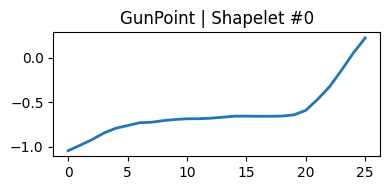

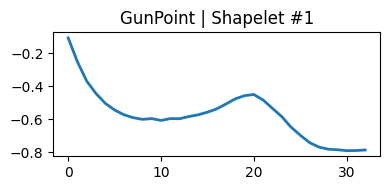

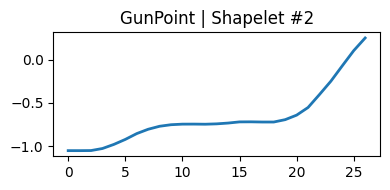


GunPoint — Shapelet localization on source series


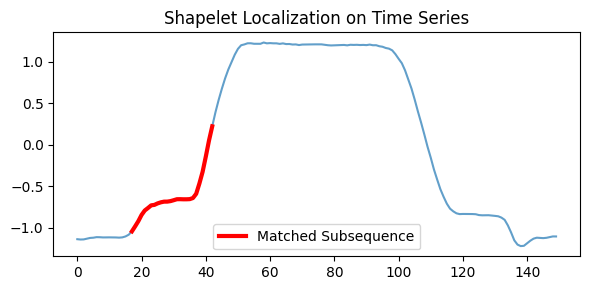


GunPoint — Shapelet on different class


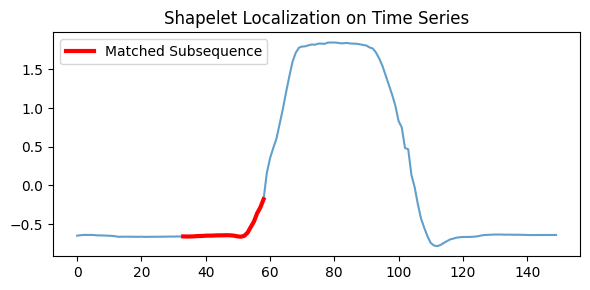


GunPoint — Closest vs Farthest samples


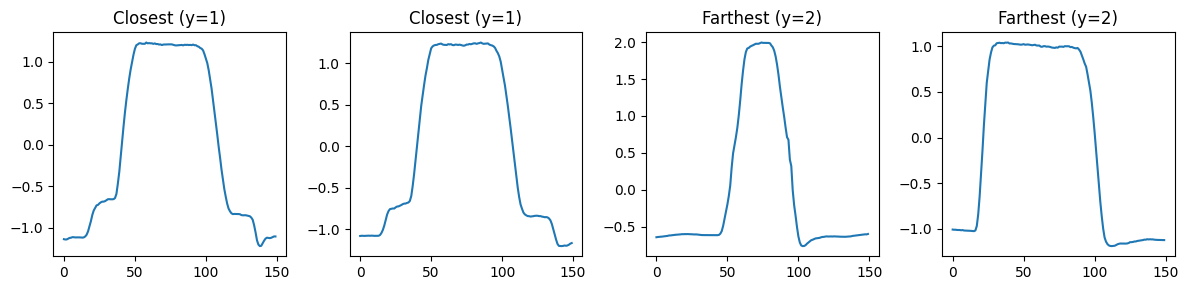


DATASET: ECGFiveDays

### ECGFiveDays — Top Shapelets


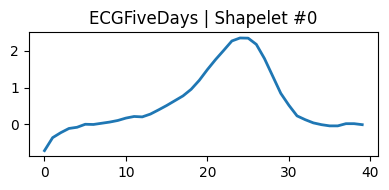

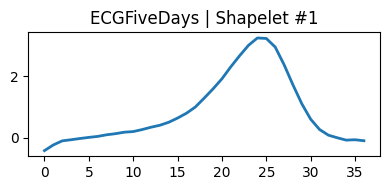

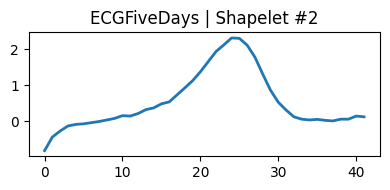


ECGFiveDays — Shapelet localization on source series


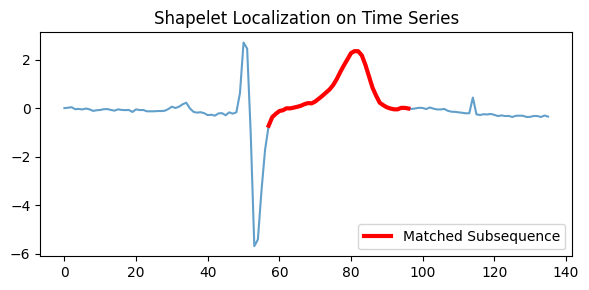


ECGFiveDays — Shapelet on different class


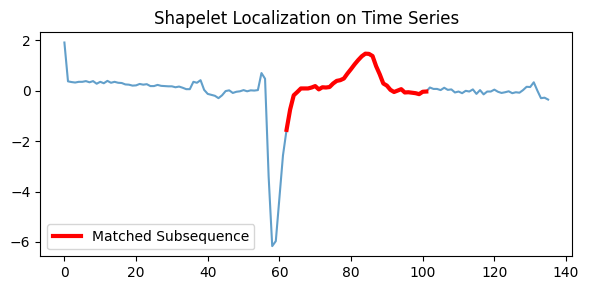


ECGFiveDays — Closest vs Farthest samples


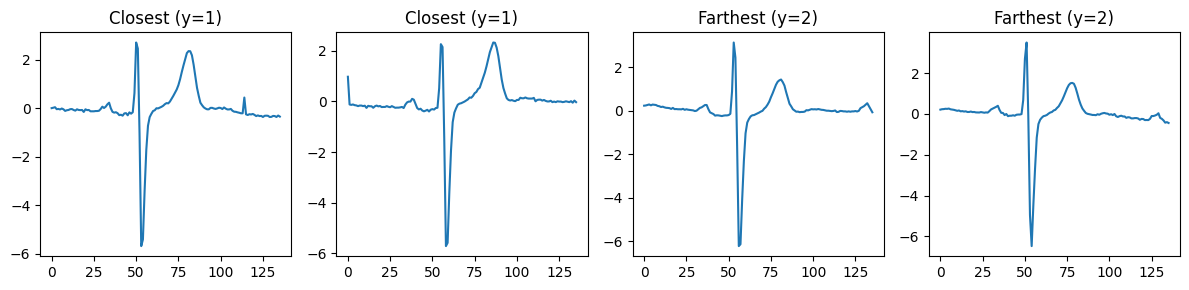


DATASET: Coffee

### Coffee — Top Shapelets


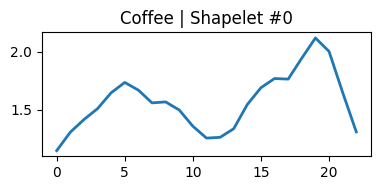

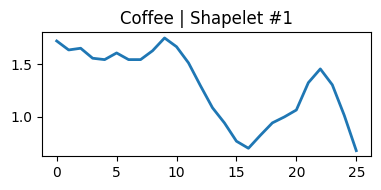

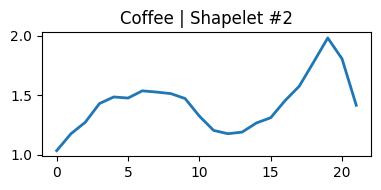


Coffee — Shapelet localization on source series


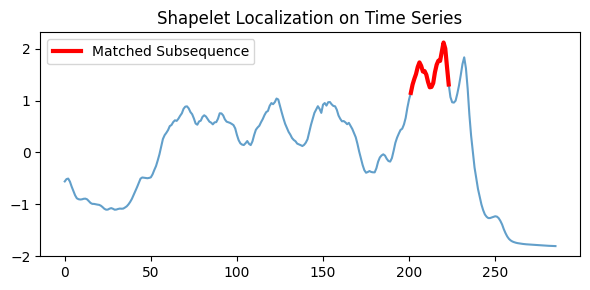


Coffee — Shapelet on different class


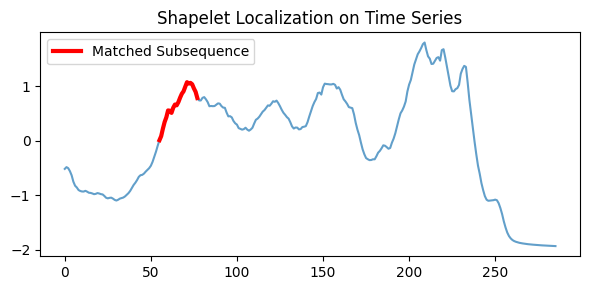


Coffee — Closest vs Farthest samples


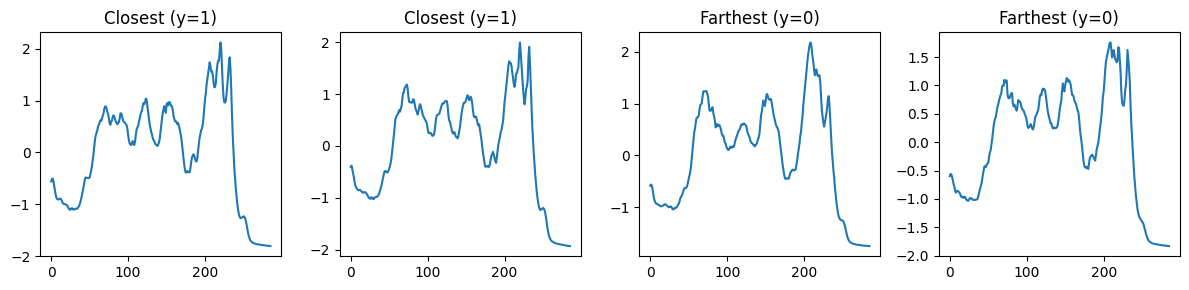


DATASET: SyntheticControl

### SyntheticControl — Top Shapelets


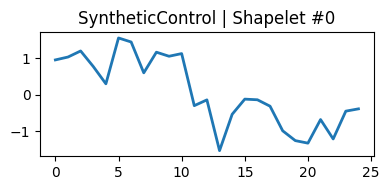

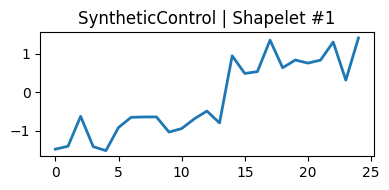

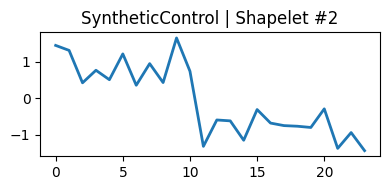


SyntheticControl — Shapelet localization on source series


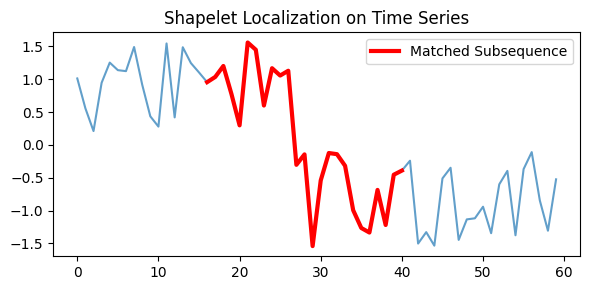


SyntheticControl — Shapelet on different class


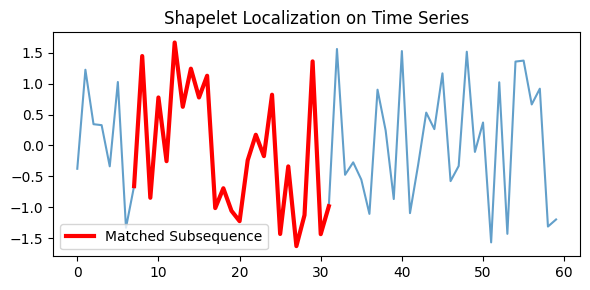


SyntheticControl — Closest vs Farthest samples


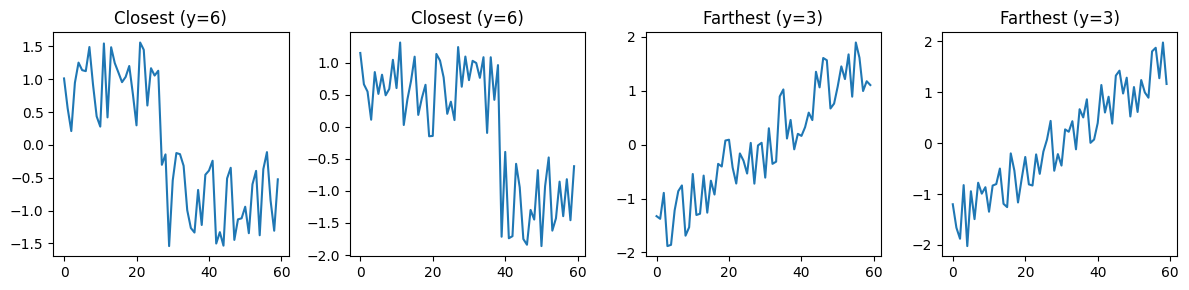

In [56]:
for res in all_results:
    print("\n" + "="*80)
    print(f"DATASET: {res['dataset']}")
    print("="*80)

    # 1. Shapelets
    viz_shapelet_only(res, n_show=3)

    # 2. Localization on source
    viz_shapelet_localization(res)

    # 3. Cross-class localization
    viz_shapelet_cross_class(res)

    # 4. Extreme samples
    viz_extreme_samples(res)


In [58]:

rows = []

for res in all_results:
    base_shapelets = res["baseline_shapelets"]
    ours_shapelets = res["clustered_shapelets"]

    div_base = dictionary_diversity(base_shapelets)
    div_ours = dictionary_diversity(ours_shapelets)

    rows.append({
        "Dataset": res["dataset"],

        "Acc Baseline": res["acc_base"],
        "Acc Ours": res["acc_ours"],
        "Δ Acc": res["acc_ours"] - res["acc_base"],

        "k Baseline": len(base_shapelets),
        "k Ours": len(ours_shapelets),
        "Reduction (%)": 100 * (1 - len(ours_shapelets) / len(base_shapelets)),

        "Diversity Baseline": div_base,
        "Diversity Ours": div_ours,
        "Δ Diversity": div_ours - div_base,
    })

df_results = pd.DataFrame(rows)

df_display = df_results.copy()

for col in [
    "Acc Baseline", "Acc Ours", "Δ Acc",
    "Diversity Baseline", "Diversity Ours", "Δ Diversity",
    "Reduction (%)"
]:
    df_display[col] = df_display[col].astype(float).round(3)

print("\n" + "="*90)
print("COMPARISON: Standard Shapelet Transform vs Our Redundancy-Filtered Approach")
print("="*90)
print(df_display.to_string(index=False))
print("="*90)




COMPARISON: Standard Shapelet Transform vs Our Redundancy-Filtered Approach
         Dataset  Acc Baseline  Acc Ours  Δ Acc  k Baseline  k Ours  Reduction (%)  Diversity Baseline  Diversity Ours  Δ Diversity
        GunPoint         0.973     0.987  0.013          50      31           38.0                 inf             inf          NaN
     ECGFiveDays         1.000     1.000  0.000          50      38           24.0                 inf             inf          NaN
          Coffee         1.000     1.000  0.000          50      36           28.0                 inf             inf          NaN
SyntheticControl         0.967     0.967  0.000          50      50            0.0                 inf             inf          NaN


/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_2037/3812467345.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  "Δ Diversity": div_ours - div_base,
